In [2]:
%pip install certifi

  Using cached certifi-2024.12.14-py3-none-any.whl.metadata (2.3 kB)
Using cached certifi-2024.12.14-py3-none-any.whl (164 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Processing speeches: 100%|██████████| 30753/30753 [04:05<00:00, 125.26it/s]


Preprocessing complete. The normalized data has been saved to /Users/markus.schneele/dataScience/results/dataset_pipeline_preprocessed_preprocessed.csv.


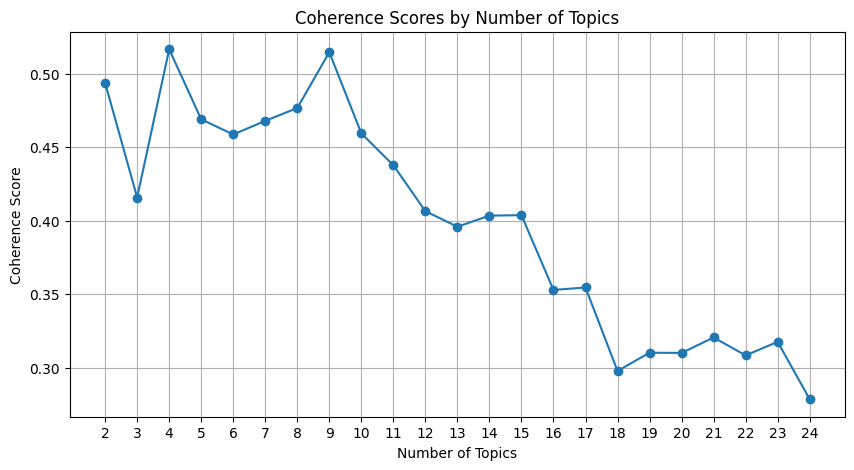

Optimal number of topics: 4
Final Model Coherence Score: 0.5173950790042816
LDA visualization has been saved to 'lda_visualization.html'. Please open this file in a web browser to view the results.
Optimal number of topics: 4
Final Model Coherence Score: 0.5173950790042816

Top 50 words for each topic:

Topic 1:
sicherheit, krieg, bundeswehr, soldat, frieden, region, einsatz, russland, freiheit, partner, zusammenarbeit, interesse, ukrain, angriff, hilfe, herausforderung, nation, waffe, konflikt, zukunft, osten, beitrag, entwicklung, stabilität, putin, mandat, verteidigung, entwicklungszusammenarbeit, abkommen, engagement, haus, kooperation, oktober, bedrohung, beziehung, außenpolitik, mission, erfolg, angriffskrieg, solidarität, freund, fähigkeit, handel, rolle, krise, kampf, wiederaufbau, sicherheitspolitik, strategie, truppe

Topic 2:
geld, kind, arbeit, familie, bildung, kommun, unternehmen, leistung, schule, bürgergeld, eltern, herausforderung, wohnung, zukunft, kommune, höhe, wirt

In [4]:
import pandas as pd
from tqdm import tqdm
import spacy
import re
import nltk
from nltk.tokenize import word_tokenize
from gensim.models.phrases import Phrases, Phraser
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import logging

# Load the German language model
nlp = spacy.load("de_core_news_sm")

# Function for loading custom stopwords
def load_custom_stopwords():
    return {  
        "mensch", "sagen", "machen", "sprechen", "zeigen", "bringen", "kommen", "geschätzter", "geschätzte", "aktuell", "beifall", "bereits",
        "bitte", "bleiben", "gehen", "stehen", "arbeiten", "wissen", "sehen", "finden", "dabei", "dafür", "dame", "damen", "dank", "danke",
        "daran", "darauf", "geben", "lassen", "stellen", "thema", "einfach", "glauben", "punkt", "darum", "darüber", "davon", "deshalb", 
        "deswegen", "deutlich", "ding", "denken", "fragen", "völlig", "verstehen", "tragen", "gut", "fall", "liegen", "natürlich", "nehmen", 
        "nein", "neu", "neue", "herren", "hause", "seite", "groß", "datum", "grundsätzlich", "erhalten", "ergebnis", "zahlen", "dr", "dr.",
        "eben", "eigentlich", "endlich", "herzlich", "herzlichen", "stärken", "chance", "frei", "leider", "konkret", "letzten", "letzter", 
        "lieb", "liebe", "geehrt", "geehrte", "geht", "genau", "gerne", "herr", "entsprechend", "erreichen", "erst", "falsch", "frau", "ganz", 
        "gar", "heute", "hoch", "insbesondere", "ja", "nächster", "nämlich", "parl", "mal", "mehr", "notwendig", "nächste", "schon", "sogar",
        "sowie", "stark", "klar", "kollege", "kollegen", "kollegin", "kolleginnen", "kolleginn", "stimmt", "tatsächlich", "vielleicht", 
        "warum", "weg", "weitere", "weiterhin", "wichtig", "wirklich", "wort", "daten", "regel", "tun", "reden", "zahl", "zusätzlich", 
        "überhaupt", "verehrt", "zuhörerinn", "zuhörer", "antwort", "aufgabe",  "monat", "million", "milliarde", "begriff", "medium",
        "woche", "jahr", "stunde", "heutig", "übrig", "sinn", "ebene", "sonstig", "eingriffe",  "ausgangssperr", "sogenannter", "verschieden", 
        "weit", "stelle", "bürger", "bürgerinnen", "bevölkerung","hau", "blick", "einzig", "euro", "welt", "linker", "problem",  "wesentlich",
        "sicht","richtung", "bissch", "bisschen", "umsetzung", "richtig", "§", "person", "name", "satz", "hand", "schön", "tisch", "mut", 
        "früh", "halb", "märz", "echt", "aufmerksamkeit","moment", "vergangenheit", "land", "deutschland", "deutsch", "minister", "ministerin",
        "politisch", "grüne", "grünen", "spd", "ministerium", "kommission", "politik", "regierung", "parlament", "partei", "bundestag", 
        "kanzlerin", "bundeskanzlerin", "bundeskanzler", "vizepräsident", "stephan", "bundesregierung", "fraktion", "cducsu", "bund",
        "ampel", "bundesrat", "staatssekretär", "spahn", "thomas", "wolfgang", "bundesrepublik", "cdu/csu", "christian", "claudia", 
        "alexander", "abgeordneten", "abgeordneter", "afd", "cdu", "fdp", "vizepräsidentin", "kubicki", "linke", "linken", "matthias", 
        "michael", "präsident", "präsidentin", "petra", "finanzminister", "union", "antrag", "gesetzentwurf", "gesetz", "gesetzlich", 
        "beschlussempfehlung", "koalitionsvertrag", "novell", "novelle", "ausschuss", "drucksache", "beschluss", "entschieden", 
        "entscheiden", "verfassungsrechtlich", "haushalt", "vorlage", "regelung", "verfahren", "beratung", "anhörung", "rede", "zitat",
        "koalitionspartner", "parlamentarisch", "bundesverfassungsgericht", "opposition", "legislatur", "lesung", "papier", "behörde", 
        "unterstützung", "unterstützen", "vorliegend", "bestehen", "demokratie", "demokratisch", "gesellschaft", "staat", "verantwortung",
        "wahlkreis", "bundesland", "bundesländer", "grund", "bereich", "möglich", "möglichkeit", "wichtigkeit", "ministerpräsidentenkonferenz",
        "bundeseinheitlich", "rahmen", "schritt", "leben", "sorgen", "setzen", "allerdings", "reform", "bundestagswahl", "prozent", 
        "wahl", "rat", "beispielsweise", "lage", "koalition", "legislaturperiode", "bündnis", "bündnisses", "länder", "öffentlich", 
        "demokrat", "fordern", "schaffen", "gelten", "schnell", "ziel", "bekommen", "forderung", "entwurf", "lösung", "zuruf", "helfen", 
        "sein", "haben", "werden", "ort", "nennen", "frage", "meinung", "vorschlag", "redner", "debatte", "situation", "maßnahme", "änderung",
        "abstimmung", "diskussion", "entscheidung", "aussprache", "stimmen", "handeln", "treffen", "freuen", "sicher", "beschließen"
    }

# Load the stopwords once
custom_stopwords = load_custom_stopwords()

stopwords = nlp.Defaults.stop_words.union(custom_stopwords)

file_path = '/Users/markus.schneele/dataScience/results/dataset_pipeline_preprocessed'

# Preprocessing Step
def preprocess_data(input_file_path, output_file_path):
    df = pd.read_csv(input_file_path)
    normalized_texts = []

    for text in tqdm(df['speech'], desc="Processing speeches"):
        clean_text = re.sub(r'[^\w\s]', '', text)
        doc = nlp(text.lower())
        lemmas = [
            token.lemma_.lower()
            for token in doc
            if token.pos_ in ['NOUN', 'ADJ'] and not token.is_digit and not token.is_stop
        ]
        filtered_lemmas = [lemma for lemma in lemmas if lemma not in custom_stopwords]
        normalized_text = " ".join(filtered_lemmas).strip()
        normalized_texts.append(normalized_text)

    df['speech'] = normalized_texts
    df.to_csv(output_file_path, index=False)
    print(f"Preprocessing complete. The normalized data has been saved to {output_file_path}.")

# Preprocess the data
preprocess_data(f"{file_path}.csv", f"{file_path}_preprocessed.csv")

# LDA Step
def lda_modelling(data_path):
    df = pd.read_csv(data_path)
    texts = df['speech'].astype(str).tolist()

    tokenized_texts = [word_tokenize(doc.lower()) for doc in texts]

    bigram = Phrases(tokenized_texts, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram)
    trigram = Phrases(bigram_mod[tokenized_texts], threshold=100)
    trigram_mod = Phraser(trigram)

    final_texts = [trigram_mod[bigram_mod[doc]] for doc in tokenized_texts]

    dictionary = Dictionary(final_texts)
    dictionary.filter_extremes(no_below=10, no_above=0.6)

    corpus = [dictionary.doc2bow(text) for text in final_texts]

    coherence_values = []
    model_list = []
    topic_range = range(2, 25, 1)

    for num in topic_range:
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num,
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            eta='auto',
            per_word_topics=True
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=final_texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    plt.figure(figsize=(10, 5))
    plt.plot(topic_range, coherence_values, marker='o')
    plt.title('Coherence Scores by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(topic_range)
    plt.grid()
    plt.show()
    logging.info("Coherence scores plotted and saved as 'coherence_scores.png'.")

    optimal_index = coherence_values.index(max(coherence_values))
    optimal_num_topics = topic_range[optimal_index]
    print(f'Optimal number of topics: {optimal_num_topics}')

    final_lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=optimal_num_topics,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=50,
        alpha='auto',
        per_word_topics=True
    )

    coherence_model_final = CoherenceModel(model=final_lda_model, texts=final_texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_final.get_coherence()
    print(f'Final Model Coherence Score: {coherence_score}')

    vis = gensimvis.prepare(final_lda_model, corpus, dictionary)
    pyLDAvis.save_html(vis, 'lda_visualization.html')
    print("LDA visualization has been saved to 'lda_visualization.html'. Please open this file in a web browser to view the results.")

    print(f'Optimal number of topics: {optimal_num_topics}')
    print(f'Final Model Coherence Score: {coherence_score}')

    print("\nTop 50 words for each topic:")
    for idx, topic in final_lda_model.show_topics(num_topics=optimal_num_topics, num_words=50, formatted=False):
        print(f"\nTopic {idx+1}:")
        print(", ".join([word for word, _ in topic]))

# Apply LDA modelling
lda_modelling(f"{file_path}_preprocessed.csv")
